## Excercise 1 - One vs One classifier

The aim of the excercise is to build a multiclass classifier using a binary classifier using a one-vs-one classifier. Similar to the tutorial, you are provided with a 3 class synthetic dataset. In a one-vs-one classifier, a binary classifier is learnt between every pair of class. You are required to write the code and visualize the decision boundaries for the one-vs-one classifier setting.

In [1]:
# Import util.ipynb for helper functions
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
# Imports

from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [3]:
fig = plt.figure(figsize=(8,8));

np.random.seed(4)

# Getting only linearly separable dataset
separable = False
while not separable:
    samples = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    green = samples[0][samples[1] == 2]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() 
                  or green[:, k].min() > blue[:, k].max() or green[:, k].min() > red[:, k].max() 
                  or blue[:, k].min() > green[:, k].max() or red[:, k].min() > green[:, k].max() for k in range(2)])

X, y = samples

y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 576x576 with 0 Axes>

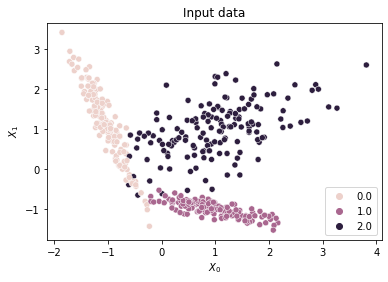

In [4]:
plot_2D_input_datapoints(X[:, :2], y)

In [5]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (315, 3)
Validation dataset:  (45, 3)
Test dataset:  (90, 3)


### Write your code below

In [6]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [7]:
# Train on the dataset
def train(X_train, Y_train, weights, num_epochs=1000, learning_rate=0.1):

    """ Method to train a logistic regression model.

    Parameters
    ------------

    X_train: ndarray (num_examples(rows) vs num_columns(columns))
    Input data on which the logistic regression model will be trained 
    to acquire optimal weights

    Y_train: ndarray (num_examples(rows) vs class_labels(columns))
    Class labels of training set

    weights: ndarray (num_features vs n_output)
    Weights used to train the network and predict on test set

    num_epochs: int
    Number of epochs you want to train the model

    learning_rate: int
    rate with which weights will be update every epoch.
    """

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(Y_train)

    history_weights = []
    epoch = 1

    # Training using Batch GD
    while epoch <= num_epochs:

        # Appending previous history weights/first initialized weights
        history_weights.append(weights)

        # Computing weighted inputs and predicting output
        w_transpose_x = np.dot(X_train, weights)
        y_pred = sigmoid(w_transpose_x)

        # Calculating gradient and updating weights
        gradient = 1 * np.dot(X_train.T, (Y_train - y_pred))
        weights += (learning_rate/n_samples) * gradient
        weights = np.round(weights, decimals=7)
        epoch += 1

    print("Training complete")

    return history_weights

In [8]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :2])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

In [9]:
# Initializing weights from uniform distribution
weights = weight_init_uniform_dist(X_normalized_train, Y_train)

Training complete
Evaluation results for classes (0, 1)
Training accuracy: 97.087
Validation accuracy: 100.000
Test accuracy: 98.438
Training complete
Evaluation results for classes (0, 2)
Training accuracy: 93.810
Validation accuracy: 93.548
Test accuracy: 98.246
Training complete
Evaluation results for classes (1, 2)
Training accuracy: 96.226
Validation accuracy: 89.655
Test accuracy: 98.246


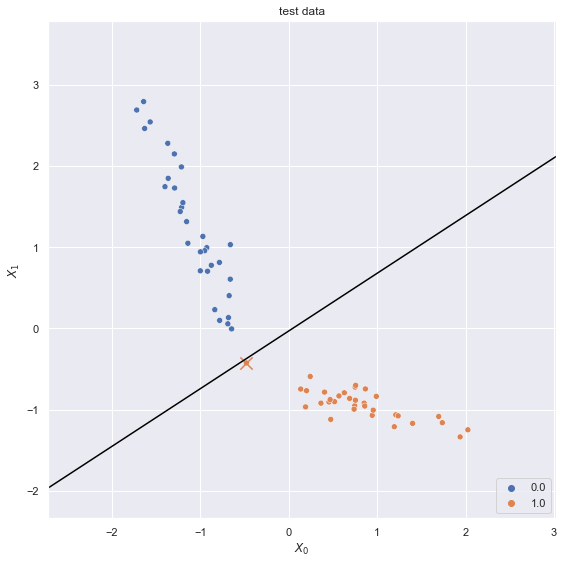

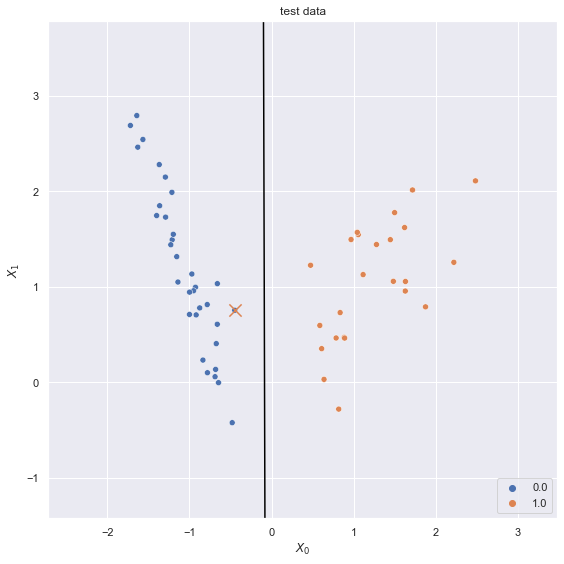

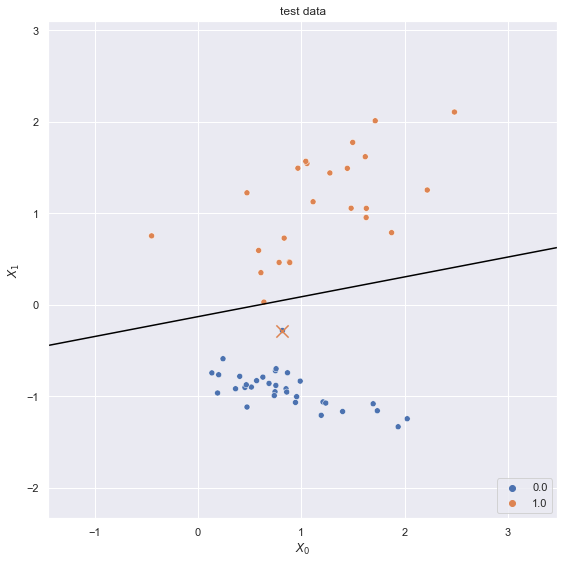

In [10]:

classes=np.unique(Y_train)
comb=combinations(classes, 2) #All possible one vs one classifier to be trained
for i in list(comb): 
    #Finding and removing the samples of class other than the pair i for training set
    binary_y_train = np.where(np.logical_and(Y_train != i[0],Y_train != i[1]) , -1,Y_train)
    other_class = np.argwhere(binary_y_train==-1)
    binary_y_train=np.delete(binary_y_train,other_class)
    binary_Xnorm_train=np.delete(X_normalized_train,other_class,axis=0)
    binary_x_train=np.delete(X_train,other_class,axis=0)
    
    #making the class label binary for training set
    binary_y_train= np.where(binary_y_train == i[0] ,0,1)
    binary_y_train=np.reshape(binary_y_train,(-1,1))

    
    #Finding and removing the samples of class other than the pair i for validation set 
    binary_y_val = np.where(np.logical_and(Y_val != i[0],Y_val != i[1]) , -1,Y_val)
    other_class=np.argwhere(binary_y_val==-1)
    binary_y_val=np.delete(binary_y_val,other_class)
    binary_x_val=np.delete(X_val,other_class,axis=0)
    
    #making the class label binary for validation set
    binary_y_val= np.where(binary_y_val == i[0] ,0,1)
    binary_y_val=np.reshape(binary_y_val,(-1,1))
   
    
    #Finding and removing the samples of class other than the pair i for validation set 
    binary_y_test = np.where(np.logical_and(Y_test != i[0],Y_test != i[1]) , -1,Y_test)
    other_class=np.argwhere(binary_y_test==-1)
    binary_y_test=np.delete(binary_y_test,other_class)
    binary_x_test=np.delete(X_test,other_class,axis=0)
    #making the class label binary for test set
    binary_y_test= np.where(binary_y_test == i[0] ,0,1)
    binary_y_test=np.reshape(binary_y_test,(-1,1))
    #binary_x_test=np.reshape(binary_x_test,(-1,binary_x_test.shape[1]))
 
    #training the binary classifier for the given class pair
    trained_weights = train(binary_Xnorm_train, binary_y_train, weights, num_epochs=50, learning_rate=0.1)
    best_weights = trained_weights[-1]

    print("Evaluation results for classes",i)
    train_acc, _ = get_prediction(binary_x_train, binary_y_train, best_weights, get_acc=True, model_type='logreg', predict='yes')
    val_acc, _ = get_prediction(binary_x_val, binary_y_val, best_weights, get_acc=True, model_type='logreg', predict='yes')
    test_acc, _ = get_prediction(binary_x_test, binary_y_test, best_weights, get_acc=True, model_type='logreg', predict='yes')

    print("Training accuracy: {:.3f}" .format(train_acc))
    print("Validation accuracy: {:.3f}" .format(val_acc))
    print("Test accuracy: {:.3f}" .format(test_acc))
    plot_decision_boundary(binary_x_test, binary_y_test, best_weights, dataset_type='test', model_type='logreg', predict='yes')